# Gaussian Mixture Models for analyzing Christman Field data
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_ml_ats/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_ml_ats/blob/main/code/unsupervised_guassianMixture_christman.ipynb)


* Author: Elizabeth Barnes (CSU)
* Date: April 18, 2022

Much of this code was taken from A. Geron's github page related to his wonderful textbook. https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb



In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = True


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

import pandas as pd

!pip install icecream
from icecream import ic


## Functions

In [3]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        
def standardize_cols(X):
    Xs = np.empty(X.shape)
    for icol in np.arange(0,X.shape[1]):
        Xs[:,icol] = (X[:,icol] - np.mean(X[:,icol]))/np.std(X[:,icol])
    return Xs

# Christman Field data

In [4]:
# Read in data from url
url = "https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/fccwx_data_2020.csv"
data = pd.read_csv(url,parse_dates=["Date"],infer_datetime_format=True)
data['dayofyear'] = data['Date'].dt.dayofyear

# for anomaly detection, try uncommenting the line below
data = data[data["Pressure [hPa]"] != 0]

# re-index the dataframe
data.reindex(index=data.index[::-1])

,Date,Temp [C],RH [%],DewPt [C],Wind [m/s],WindDir [deg. N],Gust [m/s],GustDir [deg. N],Pressure [hPa],Solar [W/m^2[,Precip [mm],dayofyear
8586,2020-01-01,-2.170,62.76,-8.315162,0.700,7,2.136,222,832.583,0.000,0.0,1
8585,2020-01-01,-2.304,59.01,-9.230945,1.295,191,3.724,191,831.717,0.000,0.0,1
8584,2020-01-01,-2.584,56.78,-9.984343,1.169,231,3.998,187,830.682,0.000,0.0,1
8583,2020-01-01,-3.807,67.52,-8.939013,0.744,145,3.567,260,829.882,0.028,0.0,1
8582,2020-01-01,-4.464,60.92,-10.869217,0.853,350,2.940,223,829.095,0.015,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16,2020-12-30,-14.530,81.80,-16.951966,0.967,343,1.980,346,843.347,0.049,0.0,365
15,2020-12-30,-14.510,83.40,-16.701044,0.476,350,1.784,33,843.463,12.650,0.0,365
2,2020-12-30,-10.010,80.40,-12.741851,0.404,106,1.803,328,825.593,0.068,0.0,365
1,2020-12-30,-9.990,76.70,-13.304007,0.591,8,2.156,336,830.078,0.040,0.0,365


In [5]:
# Decide what data you want to grab
Xdata = data[["Wind [m/s]","RH [%]"]]   # MODIFY: change the variable names to anything in the dataframe
X = Xdata.values
# X = standardize_cols(X)               # MODIFY: uncomment to standardize the columns of your data
ic(X.shape)
print('------')

ic| X.shape: (6534, 2)


------


In [6]:
gm = GaussianMixture(n_components=4, n_init=10, random_state=42)   #MODIFY: change the parameters of the Gaussian Mixture model
gm.fit(X)

GaussianMixture(n_components=4, n_init=10, random_state=42)

In [7]:
ic(gm.weights_)
ic(gm.means_)
ic(gm.covariances_)
ic(gm.converged_)
ic(gm.n_iter_)
print('------')

ic| gm.weights_: array([0.18178915, 0.15511427, 0.49980797, 0.1632886 ])
ic| gm.means_: array([[ 3.42414141, 47.15083995],
                      [ 1.66099814, 88.00245549],
                      [ 1.50028931, 54.66044669],
                      [ 5.79086692, 28.21674658]])
ic| gm.covariances_: array([[[ 1.94976651e+00,  9.28781112e+00],
                             [ 9.28781112e+00,  4.26364184e+02]],
                     
                            [[ 9.69170238e-01, -2.41889629e-01],
                             [-2.41889629e-01,  4.03608669e+01]],
                     
                            [[ 6.40706356e-01, -6.85273276e+00],
                             [-6.85273276e+00,  3.69069677e+02]],
                     
                            [[ 9.06264355e+00,  9.60721429e+00],
                             [ 9.60721429e+00,  1.38865096e+02]]])
ic| gm.converged_: True
ic| gm.n_iter_: 21


------


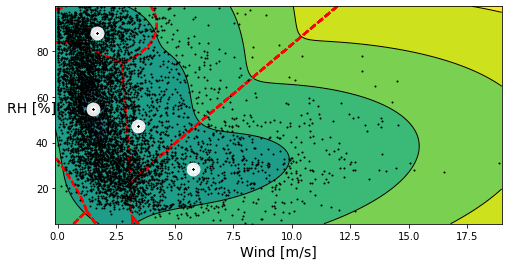

In [8]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.xlabel(Xdata.columns[0])
plt.ylabel(Xdata.columns[1])
plt.show()

# Ozone at Joshua Tree

In [9]:
# Read in data from url
url = "https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/ozone_data_joshuatreenp.csv"
data = pd.read_csv(url,parse_dates=["DATE_TIME"],infer_datetime_format=True)

# Fix data issue with Daylight Savings Time
duplicate_dates = data['DATE_TIME'][data.duplicated('DATE_TIME')]
for dup_date in duplicate_dates:
    idx = data['DATE_TIME'].eq(dup_date).idxmax()
    data.at[idx, 'DATE_TIME'] = dup_date - pd.Timedelta(value=1, unit='hours')  

# Add hour and day of year
data['HOUR'] = data['DATE_TIME'].dt.hour
data['MONTH'] = data['DATE_TIME'].dt.month
data['YEAR'] = data['DATE_TIME'].dt.year
data['DAYOFYEAR'] = data['DATE_TIME'].dt.dayofyear
data.sort_values('DATE_TIME', inplace=True, ignore_index = True)

data = data.dropna()
display(data.head())

,SITE_ID,DATE_TIME,TEMPERATURE,TEMPERATURE_DELTA,RELATIVE_HUMIDITY,SOLAR_RADIATION,OZONE,PRECIPITATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,FLOW_RATE,WINDSPEED_SCALAR,UPDATE_DATE,HOUR,MONTH,YEAR,DAYOFYEAR
0,JOT403,2010-01-01 00:00:00,3.4000,2.4000,29.0,0.0,46.0,0.0,3.8000,189.0,2.0,3.05,3.8000,10/30/14 10:27,0,1,2010,1
1,JOT403,2010-01-01 01:00:00,3.4000,2.5999,29.0,0.0,46.0,0.0,3.2000,189.0,5.0,3.05,3.2000,10/30/14 10:27,1,1,2010,1
2,JOT403,2010-01-01 02:00:00,3.5999,2.7000,26.0,0.0,46.0,0.0,3.5000,191.0,4.0,3.05,3.5000,10/30/14 10:27,2,1,2010,1
3,JOT403,2010-01-01 03:00:00,3.3000,2.8000,28.0,0.0,46.0,0.0,3.0999,190.0,5.0,3.05,3.0999,10/30/14 10:27,3,1,2010,1
4,JOT403,2010-01-01 04:00:00,3.2000,2.5999,32.0,0.0,45.0,0.0,3.5999,191.0,4.0,3.05,3.5999,10/30/14 10:27,4,1,2010,1


In [10]:
# Decide what data you want to grab
Xdata = data[["SOLAR_RADIATION","OZONE"]]   # MODIFY: change the variable names to anything in the dataframe
X = Xdata.values
# X = standardize_cols(X)                   # MODIFY: uncomment to standardize the columns of your data
ic(X.shape)
print('------')

ic| X.shape: (7150, 2)


------


In [11]:
gm = GaussianMixture(n_components=4, n_init=10, random_state=42)   #MODIFY: change the parameters of the Gaussian Mixture model
gm.fit(X)

GaussianMixture(n_components=4, n_init=10, random_state=42)

In [12]:
ic(gm.weights_)
ic(gm.means_)
ic(gm.covariances_)
ic(gm.converged_)
ic(gm.n_iter_)
print('------')

ic| gm.weights_: array([0.4334245 , 0.29062497, 0.11787158, 0.15807895])
ic| gm.means_: array([[  0.        ,  53.57754937],
                      [509.02277005,  57.95825643],
                      [926.16295848,  61.19543006],
                      [ 56.20403082,  56.77533133]])
ic| gm.covariances_: array([[[1.00000000e-06, 0.00000000e+00],
                             [0.00000000e+00, 1.35809385e+02]],
                     
                            [[4.77243876e+04, 4.86643782e+02],
                             [4.86643782e+02, 1.44888592e+02]],
                     
                            [[7.27046248e+03, 2.31876833e+02],
                             [2.31876833e+02, 9.12726979e+01]],
                     
                            [[3.65688931e+03, 1.13454589e+02],
                             [1.13454589e+02, 2.25582954e+02]]])
ic| gm.converged_: True
ic| gm.n_iter_: 31


------


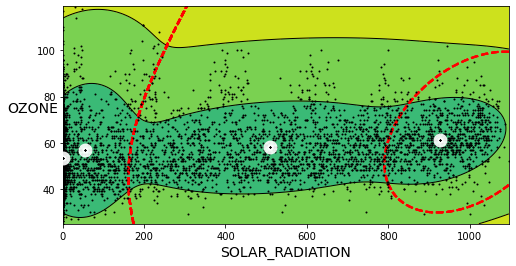

In [13]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.xlabel(Xdata.columns[0])
plt.ylabel(Xdata.columns[1])
plt.show()